In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv('MS.csv')
print(df.shape)
df.head(2)

(252, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-07-08,43.590000,43.959999,43.290001,43.490002,42.180561,7060200
1,2019-07-09,43.080002,43.869999,43.020000,43.779999,42.461830,5941900


In [6]:
close_price = df['Close'].values
close_price[:5]

array([43.490002, 43.779999, 43.310001, 44.18    , 44.869999])

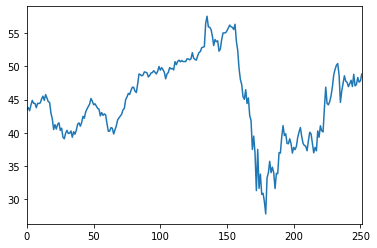

In [7]:
df.Close.plot()

In [8]:
train_data = close_price[:222]
test_data = close_price[222:]
print(train_data.shape, test_data.shape)
train_data[:5]

(222,) (30,)


array([43.490002, 43.779999, 43.310001, 44.18    , 44.869999])

In [12]:
scaler = StandardScaler()
train_data_norm = scaler.fit_transform(train_data.reshape(-1,1))
train_data_norm[:5]

array([[-0.16762906],
       [-0.12130209],
       [-0.19638419],
       [-0.05740201],
       [ 0.05282521]])

In [11]:
train_data_norm_lstm = torch.FloatTensor(train_data_norm_lstm).view(-1)
train_data_norm[:5]

tensor([-0.1676, -0.1213, -0.1964, -0.0574,  0.0528])

In [67]:
seq_length = 30

def get_in_out_sequence(input_data, seq_len):
    in_out_seq = []
    len_input = len(input_data)
    for i in range(len_input-seq_len):
        train_seq = input_data[i:i+seq_len]
        train_label = input_data[i+seq_len:i+seq_len+1]
        in_out_seq.append((train_seq, train_label))
    return in_out_seq

In [68]:
train_inout_seq = get_in_out_sequence(train_tensor, seq_length)
train_inout_seq[:3]

[(tensor([-0.1676, -0.1213, -0.1964, -0.0574,  0.0528, -0.0175, -0.0175, -0.1229,
          -0.0175, -0.0239, -0.0063,  0.0896,  0.1535,  0.0528,  0.1918,  0.1103,
           0.0209,  0.0033, -0.2571, -0.3865, -0.6469, -0.5303, -0.6357, -0.5223,
          -0.4855, -0.6676, -0.6149, -0.8322, -0.8689, -0.7347]),
  tensor([-0.6660])),
 (tensor([-0.1213, -0.1964, -0.0574,  0.0528, -0.0175, -0.0175, -0.1229, -0.0175,
          -0.0239, -0.0063,  0.0896,  0.1535,  0.0528,  0.1918,  0.1103,  0.0209,
           0.0033, -0.2571, -0.3865, -0.6469, -0.5303, -0.6357, -0.5223, -0.4855,
          -0.6676, -0.6149, -0.8322, -0.8689, -0.7347, -0.6660]),
  tensor([-0.7411])),
 (tensor([-0.1964, -0.0574,  0.0528, -0.0175, -0.0175, -0.1229, -0.0175, -0.0239,
          -0.0063,  0.0896,  0.1535,  0.0528,  0.1918,  0.1103,  0.0209,  0.0033,
          -0.2571, -0.3865, -0.6469, -0.5303, -0.6357, -0.5223, -0.4855, -0.6676,
          -0.6149, -0.8322, -0.8689, -0.7347, -0.6660, -0.7411]),
  tensor([-0.7347]))

In [104]:
class TS_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        self.hidden_cell = (torch.zeros(1,1, self.hidden_layer_size),
                           torch.zeros(1,1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [105]:
model = TS_LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

TS_LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [106]:
epochs = 100
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.03658075
epoch:  26 loss: 0.00002508
epoch:  51 loss: 0.00024543
epoch:  76 loss: 0.00236123
epoch:  99 loss: 0.0022042338


In [107]:
fut_pred = 30

test_input = train_data_norm[-seq_length:].tolist()
print(len(test_input))
train_data_norm[:2]

30


tensor([-0.1676, -0.1213])

In [108]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_input[-seq_length:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_input.append(model(seq).item())

In [109]:
len(test_input)
# del test_input

60

In [110]:
actual_pred = scaler.inverse_transform(np.array(test_input[seq_length:]))
print(len(actual_pred))
actual_pred[:4]

30


array([40.57424724, 40.97804296, 41.858704  , 43.08663273])

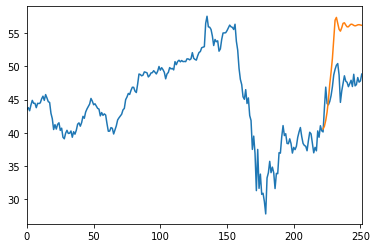

In [119]:
pd.Series(close_price).plot()
pd.Series(actual_pred,np.arange(len(train_data),len(close_price),1)).plot()

In [103]:
close_price[-5:]

array([47.240002, 48.299999, 47.610001, 47.790001, 48.82    ])

In [131]:
inputs =[torch.randn(1, 3) for _ in range(5)]
for i in inputs:
    print(i)

tensor([[-0.6251,  0.4428, -2.0293]])
tensor([[ 0.5338, -1.4102, -0.0755]])
tensor([[0.0808, 0.1651, 0.0108]])
tensor([[ 1.1662, -0.4886, -0.8625]])
tensor([[0.9688, 0.1675, 0.4591]])


In [127]:
(torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))

(tensor([[[0.5501, 1.3777, 2.0261]]]), tensor([[[-0.4853, -1.9215, -1.2074]]]))

In [130]:
torch.randn(1, 3)

tensor([[-0.1016,  0.5238, -1.2643]])

# ARIMA

In [13]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
ts_model = ARIMA(train_data, order=(10,1,2))
model_fit = ts_model.fit(disp=1)

In [60]:
output = model_fit.forecast(30)

In [61]:
output[0]

array([40.00481813, 40.44456762, 39.44145705, 40.78803082, 39.90521484,
       40.74620073, 40.60504751, 40.29250247, 40.86828858, 40.08062559,
       40.758916  , 40.33072566, 40.49031967, 40.65565264, 40.31724406,
       40.69406677, 40.34570089, 40.53614005, 40.46048709, 40.4073987 ,
       40.50987534, 40.37881527, 40.47516482, 40.38023025, 40.4291246 ,
       40.36820852, 40.38955679, 40.36740046, 40.33325003, 40.3813737 ])

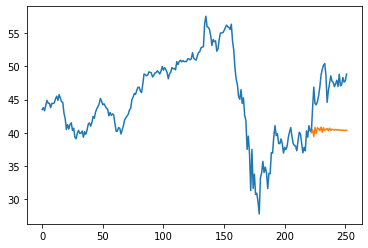

In [63]:
plt.plot(close_price)
plt.plot(np.arange(len(train_data),len(close_price)), output[0])

In [3]:
import pmdarima as pmd

In [27]:
model = pmd.auto_arima(train_data, start_p=1, start_q=1, test="adf", seasonal=False, m=2)

In [30]:
model.predict(30).tolist()

[40.30133242627456,
 40.74404572980792,
 40.00190924012012,
 40.82335365275737,
 39.97652282068034,
 40.71474936205969,
 40.06659027407246,
 40.548938775117115,
 40.17080216550961,
 40.39848627422099,
 40.241822971077006,
 40.289871847603486,
 40.26917299661426,
 40.22215565111592,
 40.261158980974855,
 40.182971645407406,
 40.23167184660967,
 40.15869614142469,
 40.19292079593599,
 40.13915465172613,
 40.15282540560582,
 40.11862107093276,
 40.11515798292483,
 40.09494253946674,
 40.08081768054773,
 40.0681206320723,
 40.04921471623366,
 40.039075680032916,
 40.019296587125446,
 40.00885075216709]

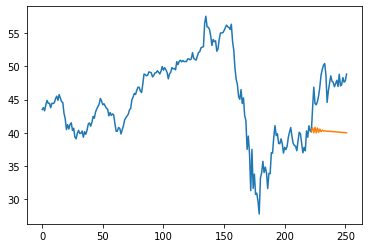

In [29]:
plt.plot(close_price)
plt.plot(np.arange(len(train_data),len(close_price)), model.predict(30))